In [1]:
from __future__ import absolute_import
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP, OneOverSqr
from dsp_utils import seg_time
from siggen_utils import herzfeld_block
from plt_utils import plot_by_key,plot_segments

from runners import Runner


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
P0=0
Pplus=1
Pminus=-1
Pchannel=np.nan

TfN1 = 100
TfA = 300
TfN2 = 100

TsN=60
TsA=120
TsB=20
TsC=20

# T=300
TaN=150
TaB=120

playlist = {
'frogs': [(P0,TfN1),((P0,Pplus),TfA),(P0,TfN2)],
'anti_frogs': [(P0,TfN1),(Pplus,TfA),(P0,TfN2)],
'savings': 2 * [(P0, TsN), (Pplus, TsA), (Pminus, TsB), (Pchannel, TsC)],
'sprecovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 20),
               (Pchannel, 400)],
'spOVRrecovery': [(P0, 192),
               (Pplus, 1000),
               (Pminus, 20),
               (Pchannel, 400)],
'evrecovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 20),
               (Pplus, 20),
               (Pchannel, 400)],
'lng_recovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 384),
               (Pchannel, 400)],    
'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'ANB0':[(P0, TaN),(Pminus, TaB)],
'ANB1':[(P0, TaN),(Pplus,13),(P0, TaB),(Pminus, TaB)],
'ANB2':[(P0, TaN),(Pplus,41),(P0, TaB),(Pminus, TaB)],
'ANB3':[(P0, TaN),(Pplus,112),(P0, TaB),(Pminus, TaB)],
    }

def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
playlist.update(generate_herzfeld_scenarios(**hrz_params))
        

In [3]:
frog_playlist = {
f'frogs{f}': [(P0,TfN1),((P0,Pplus),TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])}

frog_playlist_a = {
f'anti_frogs{f}': [(P0,TfN1),(Pplus,TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])} 

frog_playlist.update(frog_playlist_a)

In [4]:
# baseline_settings = {'criterion':'MSE', 'k':[0.1,0,5], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':1}
# baseline_settings = {'criterion':'MSE', 'k':[0.5,0,2], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':1}
baseline_settings = {'criterion':'MSE', 'k':[0.3,0,1], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':1}
# baseline_settings = {'criterion':'MSE', 'k':[[0.1,0,5]], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':4}

model_construct_args =  dict(n_inputs = 3,
                  n_hidden = 4*512,
                  n_outs = 1,
                  en_bias = False,
                 b_high=5, first_layer_init='ones',
                first_layer_weights_trainable = True,
                  nl = lambda : OneOverSqr(w=0.5), skip_gain= 0.4)

# model_construct_args =  dict(n_inputs = 3,
#                   n_hidden = 4*512,
#                   n_outs = 1,
#                    b_high=5, ones_first_layer=True,
#                    nl = lambda : OneOverSqr(w=1))

test_vec= np.stack([np.linspace(-10,10,200), 
                    np.zeros(200),
                    np.zeros(200)]).T

In [5]:
baseline_runner = Runner(model_construct_args=model_construct_args,
                test_vec=test_vec,
                **baseline_settings)

model reset


In [6]:
results = baseline_runner.run_multiple(playlist)

running scenario: frogs
running scenario: anti_frogs
running scenario: savings
running scenario: sprecovery
running scenario: spOVRrecovery
running scenario: evrecovery
running scenario: lng_recovery
running scenario: AB0
running scenario: AB1
running scenario: AB2
running scenario: AB3
running scenario: ANB0
running scenario: ANB1
running scenario: ANB2
running scenario: ANB3
running scenario: herzfeld,z=0.1
running scenario: herzfeld,z=0.5
running scenario: herzfeld,z=0.9


In [7]:
def do_plots(results,playlist,figsize=(24, 12)):
    plt.figure(figsize=figsize)
    plt.subplot(2,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=2,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1]+playlist['savings'][2][1]+playlist['savings'][3][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.subplot(2,3,2)
    plot_by_key(results, ['frogs','anti_frogs'],visu_offsets = [0, 0.00])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')
    plt.subplot(2,3,3)
    plot_by_key(results,
                ['sprecovery','spOVRrecovery','lng_recovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,4)
    plot_by_key(results,
                ['AB0','AB1','AB2','AB3'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,5)
    plot_by_key(results,
                ['ANB0','ANB1','ANB2','ANB3'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,6)
    for iz, z in enumerate(hrz_params['z_list']):
        deltas = []
        scenario = f'herzfeld,z={z}'
        this_result = results[scenario]
        block_length = playlist[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append(this_result.u_lp[pointer-1]-this_result.u_lp[pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')
    plt.legend(loc='upper right')
    plt.xlabel('block #')
    plt.ylabel('adaptation delta channel2-channel1')

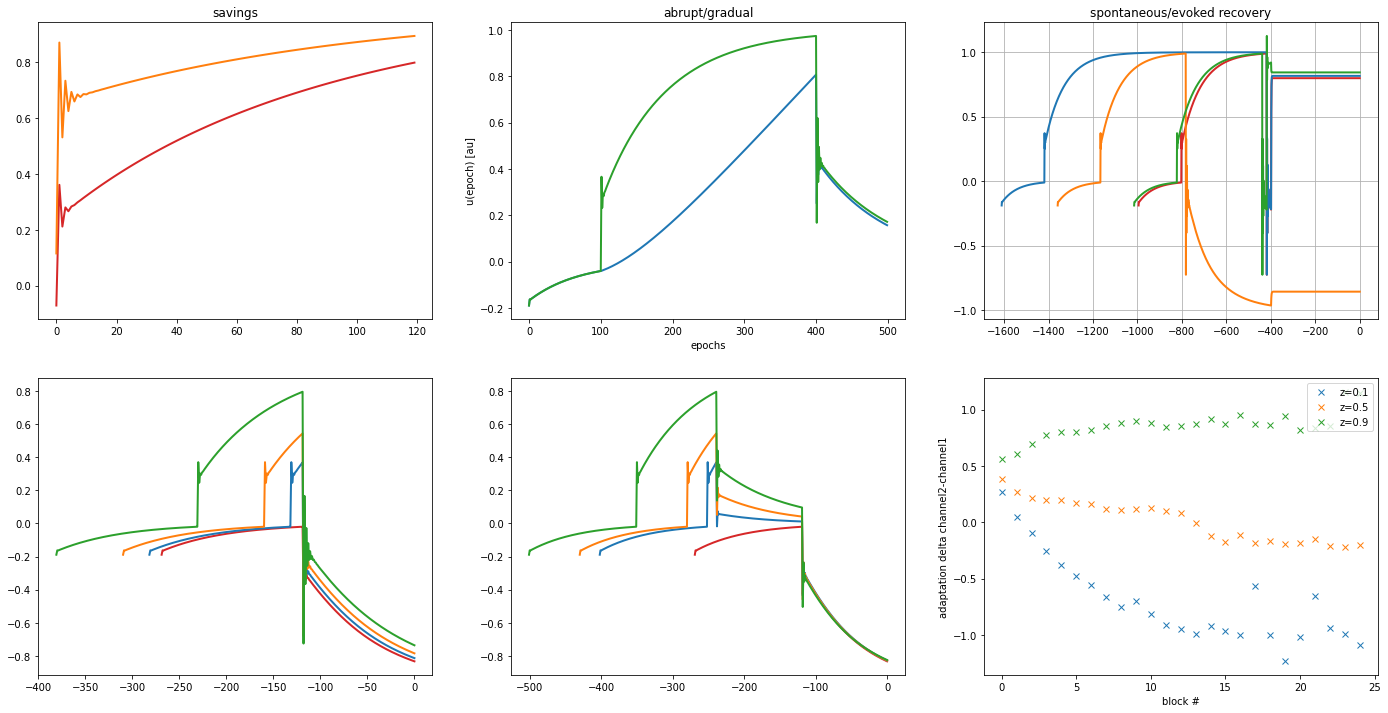

In [8]:
do_plots(results,playlist)
plt.subplot(2,3,1)
plt.title(f'savings')
plt.subplot(2,3,2)
plt.title(f'abrupt/gradual')
plt.subplot(2,3,3)
plt.title(f'spontaneous/evoked recovery')
plt.grid(True)
plt.show()

(-1.0, 0.0)

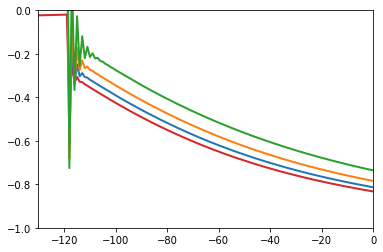

In [9]:
plot_by_key(results,
                ['AB0','AB1','AB2','AB3'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
plt.xlim([-130,0])
plt.ylim([-1,0])


In [10]:
plain_frog_results = baseline_runner.run_multiple(frog_playlist)

running scenario: frogs0
running scenario: frogs1
running scenario: frogs2
running scenario: anti_frogs0
running scenario: anti_frogs1
running scenario: anti_frogs2


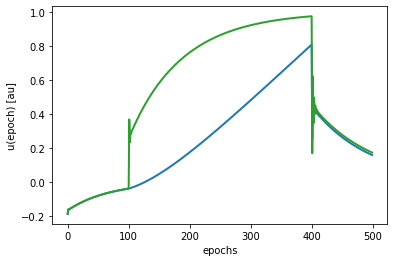

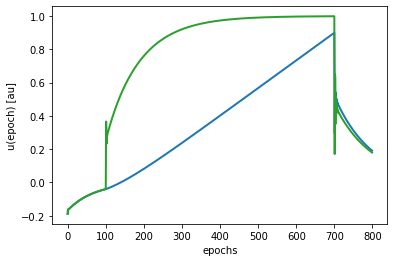

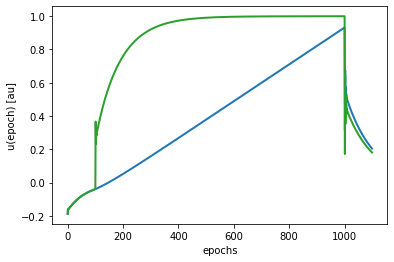

In [11]:
for f in range(3):
    plt.figure()
    plot_by_key(plain_frog_results, [f'frogs{f}',f'anti_frogs{f}'],visu_offsets = [0, 0.00])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')

(990.0, 1150.0)

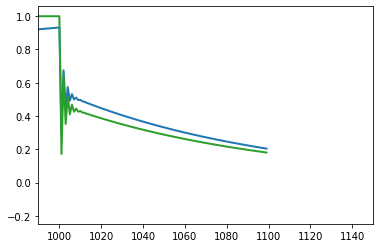

In [12]:
f = 2
plot_by_key(plain_frog_results, [f'frogs{f}',f'anti_frogs{f}'],visu_offsets = [0, 0.00])
plt.xlim([1000-10,1150])

In [13]:
kosher_runner = Runner(model_construct_args={**model_construct_args, 'skip_gain': 0.0},
                test_vec=test_vec,
                **baseline_settings)

model reset


In [14]:
kosher_results = kosher_runner.run_multiple(playlist)

running scenario: frogs
running scenario: anti_frogs


KeyboardInterrupt: 

In [ ]:
do_plots(kosher_results,playlist)

In [ ]:
plt.figure(figsize=(3, 3))
foo = playlist['lng_recovery']
tau = baseline_runner.tau_u
test_sig = test_vec[:,0]
t_vec_Plus = np.arange(seg_time(foo,1,'start'),seg_time(foo,1,'end'),10)
t_vec_Pminus = np.arange(seg_time(foo,2,'start'),seg_time(foo,2,'end'),10)
for p,t_vec in enumerate([t_vec_Plus, t_vec_Pminus]):
  for i,t in enumerate(t_vec):
    shade = 0.9 - float(i) /2/ len(t_vec)
    plt.plot(test_sig, 1/tau*(results['lng_recovery'].test_output[t].squeeze()-test_sig),
            color=[0,shade,0] if p==1 else [shade,shade,shade],
            linewidth=2)
    plt.ylim([-0.3,0.3])
    plt.xlim([-5,5])
    plt.yticks([0])
plt.xlabel('motor output')
plt.ylabel('drift velocity')
plt.grid()



In [ ]:
plain_frog_results = baseline_runner.run_multiple(frog_playlist)

In [ ]:
combo_settings = {'criterion':'MSE', 'k':[0,0,0,1], 'learning_rate':1e-4, 'sigma_noi':0.0, 'tau_u':1, 'enable_combo': True}
# baseline_settings = {'criterion':'MSE', 'k':[[0.1,0,5]], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':4}


combo_model_construct_args =  dict(n_inputs = 4,
                  n_hidden = 4*512,
                  n_outs = 1,
                  en_bias = False,
                 b_high=5, first_layer_init='ones',
                first_layer_weights_trainable = True,
                  nl = lambda : OneOverSqr(w=0.5), skip_gain= 0.3)

combo_test_vec= np.stack([np.linspace(-10,10,200), 
                    np.zeros(200),
                    np.zeros(200),
                    np.zeros(200)]).T

In [ ]:
combo_runner = Runner(model_construct_args=combo_model_construct_args,
                test_vec=combo_test_vec,
                **combo_settings)

In [ ]:
combo_results = combo_runner.run_multiple(playlist)

In [ ]:
do_plots(combo_results,playlist)

In [ ]:
combo_frog_results = combo_runner.run_multiple(frog_playlist)

In [ ]:
for f in range(3):
    plt.figure()
    plot_by_key(combo_frog_results, [f'frogs{f}',f'anti_frogs{f}'],visu_offsets = [0, 0.00])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')

In [23]:
uni_settings = {'criterion':'MSE', 'k':[0.3,0,1], 'learning_rate':0.5e-4, 'sigma_noi':0.0, 'tau_u':1, 'auto_steps':10}


uni_model_construct_args =  dict(n_inputs = 3,
                  n_hidden = 4*512,
                  n_outs = 1,
                  en_bias = False,
                 b_high=5, first_layer_init='uniform_unity',
                first_layer_weights_trainable = True,
                  nl = lambda : OneOverSqr(w=0.5,c=-0.0), skip_gain= 0.5)

# model_construct_args =  dict(n_inputs = 3,
#                   n_hidden = 4*512,
#                   n_outs = 1,
#                    b_high=5, ones_first_layer=True,
#                    nl = lambda : OneOverSqr(w=1))

test_vec= np.stack([np.linspace(-10,10,200), 
                    np.zeros(200),
                    np.zeros(200)]).T

In [24]:
uni_runner = Runner(model_construct_args=uni_model_construct_args,
                test_vec=test_vec,
                **uni_settings)

model reset


In [25]:
uni_results = uni_runner.run_multiple(playlist)

running scenario: frogs
running scenario: anti_frogs
running scenario: savings
running scenario: sprecovery
running scenario: spOVRrecovery
running scenario: evrecovery
running scenario: lng_recovery
running scenario: AB0
running scenario: AB1
running scenario: AB2
running scenario: AB3
running scenario: ANB0
running scenario: ANB1
running scenario: ANB2
running scenario: ANB3
running scenario: herzfeld,z=0.1
running scenario: herzfeld,z=0.5
running scenario: herzfeld,z=0.9


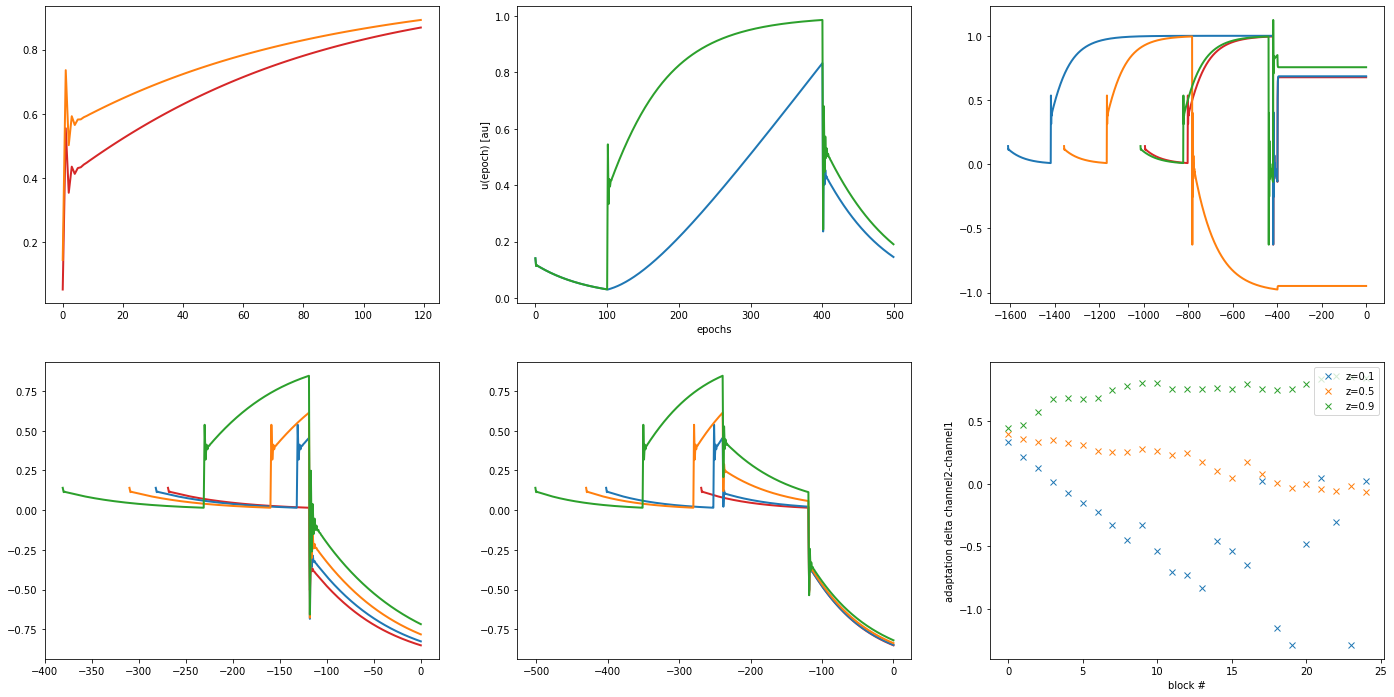

In [26]:
do_plots(uni_results,playlist)